# Import libraries

In [4]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math  
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential 
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import yfinance as yf

print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.9.2
Num GPUs: 1


In [6]:
np.random.seed(42)
tf.random.set_seed(42)

# Preprocessing

In [7]:
def load(symbol,start_date,end_date):
  df = yf.download(symbol, start=start_date, end=end_date)
  return df

In [8]:
def count(start_date,end_date):
  end_date_object = datetime.strptime(end_date, '%Y-%m-%d').date()
  start_date_object = datetime.strptime(start_date, '%Y-%m-%d').date()
  return (end_date_object-start_date_object)

In [9]:
def plot(df):
  df_plot = df.copy()

  num_cols = 2
  num_rows = int(round(df_plot.shape[1] / num_cols, 0))

  fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(20, 10))
  for i, ax in enumerate(fig.axes):
          sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
          ax.tick_params(axis="x", rotation=30, labelsize=15, length=0)
          ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

In [10]:
def preprocess(df, seq_len, split=0.8):
  sequence_length = seq_len

  stock_features = ['High', 'Low', 'Open', 'Close', 'Volume']

  train_df = df.sort_values(by=['Date']).copy()

  data = pd.DataFrame(train_df)
  data_filtered = data[stock_features]

  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']

  data_filtered_ext.tail()

  nrows = data_filtered.shape[0]

  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  print(np_data.shape)

  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)

  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  index_Close = data.columns.get_loc("Close")

  train_data_len = math.ceil(np_data_scaled.shape[0] * split)

  train_data = np_data_scaled[0:train_data_len, :]
  val_data = np_data_scaled[train_data_len - sequence_length:, :]

  def partition_rnn(sequence_length, data):
      x, y = [], []
      data_len = data.shape[0]
      for i in range(sequence_length, data_len):
          x.append(data[i-sequence_length:i,:])
          y.append(data[i, index_Close]) 
      
      x = np.array(x)
      y = np.array(y)
      return x, y

  x_train, y_train = partition_rnn(sequence_length, train_data)
  x_val, y_val = partition_rnn(sequence_length, val_data)

  return stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val

# Build RNN model

In [11]:
def create_RNN(hidden_units, input_shape, rnn_type, lr, loss, drop=0.2):
  model = Sequential()
  if rnn_type == 'RNN':

    model.add(SimpleRNN(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(drop))
    model.add(SimpleRNN(hidden_units, return_sequences=True))
    model.add(SimpleRNN(hidden_units, return_sequences=False))

  elif rnn_type == 'LSTM':

    model.add(LSTM(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(drop))
    model.add(LSTM(hidden_units, return_sequences=True))
    model.add(LSTM(hidden_units, return_sequences=False))

  elif rnn_type == 'GRU':

    model.add(GRU(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(drop))
    model.add(GRU(hidden_units, return_sequences=True))
    model.add(GRU(hidden_units, return_sequences=False))

  model.add(Dense(1))

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=loss)

  return model

In [12]:
def loss_plot(history, epochs, rnn_type ="Vanilla RNN"):
  fig, ax = plt.subplots(figsize=(12, 5), sharex=True)
  sns.lineplot(data=history.history["loss"])
  sns.lineplot(data=history.history["val_loss"])
  plt.title(f"Loss Curve w/ {rnn_type}")
  plt.ylabel("Loss")
  plt.xlabel("Steps")
  plt.legend(["Train", "Val"], loc="upper left")
  plt.grid()
  plt.show()

In [13]:
def evaluate(model, x_train, y_train, x_val, y_val, scaler_pred, epoch, batch_size): #SimpleRNN_model | LSTM_model | GRU_model
  epochs = epoch
  batch_size = batch_size
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(x_val, y_val)
                      #,callbacks=[early_stop])
                    )
                    
  y_pred_scaled = model.predict(x_val)
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

  MAE = mean_absolute_error(y_val_unscaled, y_pred)
  MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
  MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100

  return history, y_pred, MAE, MAPE, MDAPE

In [25]:
def evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01", rnn_type="LSTM" ):
  train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
  val = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_val'})
  val.insert(1, "y_pred", y_pred, True)
  df_union = pd.concat([val, train])

  df_union_zoom = df_union[df_union.index > display_start_date]

  fig, ax1 = plt.subplots(figsize=(12, 5))
  plt.title(f"Stock Price Prediction w/ {rnn_type}")
  plt.ylabel(stockname)
  sns.lineplot(data=df_union_zoom[['y_train',  'y_val', 'y_pred']], linewidth=1.0, dashes=False, ax=ax1)
  plt.legend()
  plt.grid()
  plt.show()

# Stock company

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-01-02  1750.089966  1790.660034  1744.500000  1784.750000  1784.750000   
2018-01-03  1790.229980  1829.020020  1785.000000  1824.160034  1824.160034   
2018-01-04  1838.540039  1848.900024  1802.030029  1807.250000  1807.250000   
2018-01-05  1820.180054  1825.500000  1805.800049  1823.540039  1823.540039   
2018-01-08  1827.489990  1874.949951  1825.189941  1851.810059  1851.810059   

            Volume  
Date                
2018-01-02  475500  
2018-01-03  525000  
2018-01-04  592600  
2018-01-05  358600  
2018-01-08  555600  
1784 days, 0:00:00


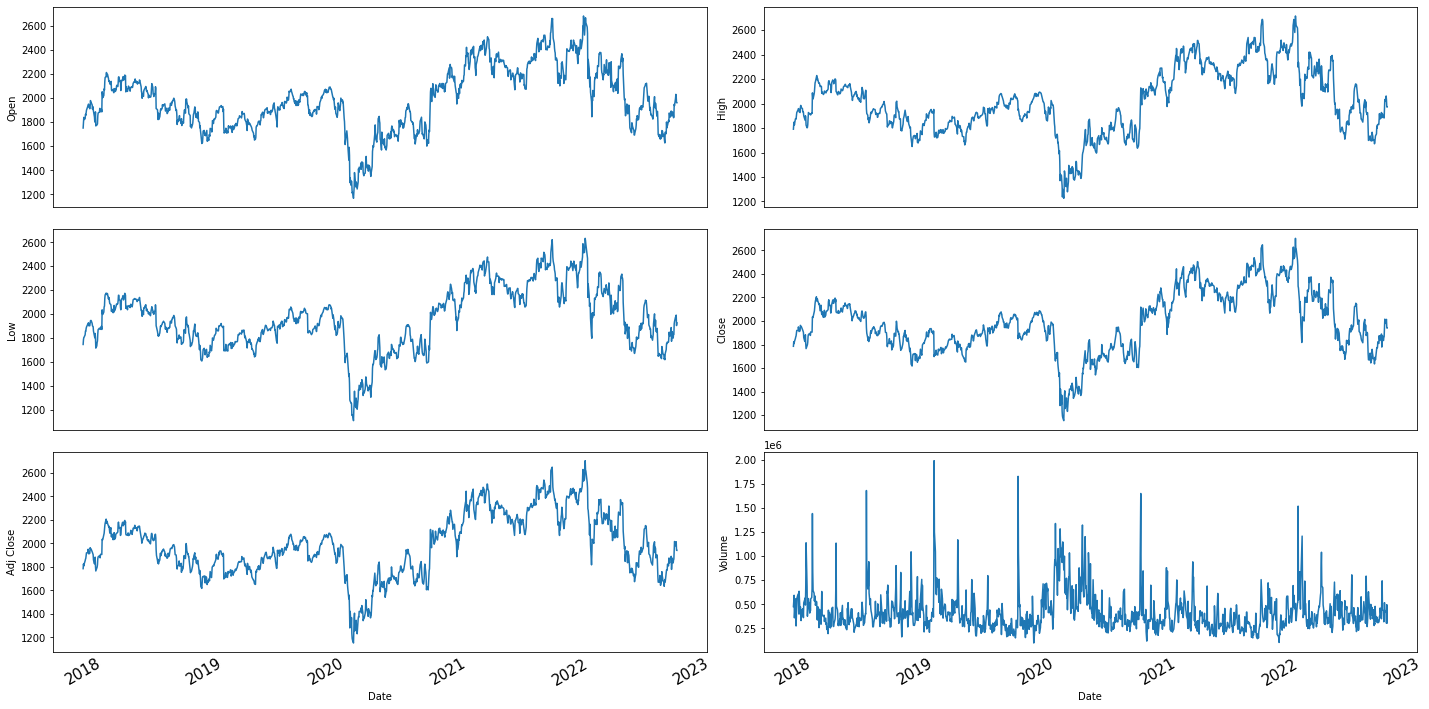

In [15]:
symbol ='BKNG'
stock_company = 'Booking Holdings Inc'

start_date = '2018-01-01'
end_date =  date.today().strftime("%Y-%m-%d")

df = load(symbol,start_date, end_date)
print(df.head())

print(count(start_date, end_date))

plot(df)

# RNN

In [16]:
sequence_length = 50 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)

h0 = x_train.shape[1] * x_train.shape[2]

(1231, 5)


In [17]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"


SimpleRNN_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='RNN', lr=lr, loss=loss)

history, y_pred_simplernn, MAE_simplernn, MAPE_simplernn, MDAPE_simplernn = evaluate(SimpleRNN_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
30/30 [==============================] - 14s 261ms/step - loss: 0.8668 - val_loss: 0.0377
Epoch 2/50
30/30 [==============================] - 3s 109ms/step - loss: 0.0300 - val_loss: 0.0321
Epoch 3/50
30/30 [==============================] - 3s 116ms/step - loss: 0.0664 - val_loss: 2.3400
Epoch 4/50
30/30 [==============================] - 4s 129ms/step - loss: 2.2690 - val_loss: 0.0505
Epoch 5/50
30/30 [==============================] - 3s 112ms/step - loss: 0.0599 - val_loss: 0.0352
Epoch 6/50
30/30 [==============================] - 3s 111ms/step - loss: 0.0413 - val_loss: 0.0253
Epoch 7/50
30/30 [==============================] - 3s 114ms/step - loss: 0.0351 - val_loss: 0.0245
Epoch 8/50
30/30 [==============================] - 3s 109ms/step - loss: 0.0372 - val_loss: 0.0327
Epoch 9/50
30/30 [==============================] - 3s 109ms/step - loss: 0.0296 - val_loss: 0.0203
Epoch 10/50
30/30 [==============================] - 3s 110ms/step - loss: 0.0239 - val_loss: 0.017

In [40]:
SimpleRNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 250)           64000     
                                                                 
 dropout (Dropout)           (None, 50, 250)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 250)           125250    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 250)               125250    
                                                                 
 dense (Dense)               (None, 1)                 251       
                                                                 
Total params: 314,751
Trainable params: 314,751
Non-trainable params: 0
_________________________________________________________________


In [37]:
print( MAE_simplernn, MAPE_simplernn, MDAPE_simplernn)

79.20114110931148 3.8917502528867205 3.426033327640117


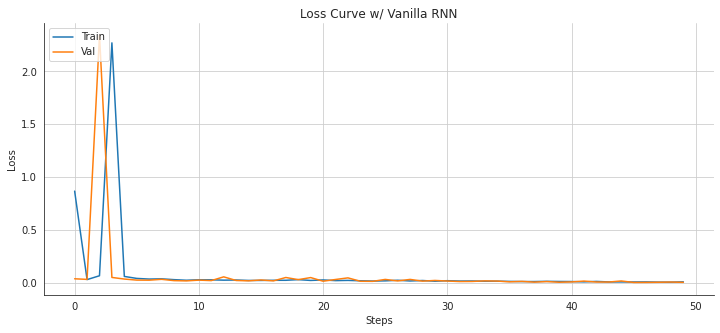

In [26]:
loss_plot(history, epochs=epoch, rnn_type ="Vanilla RNN")

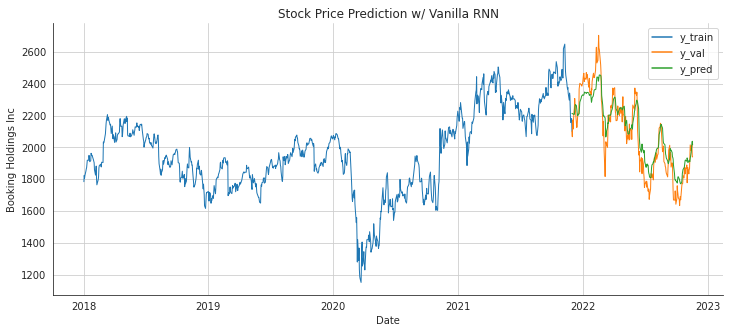

In [27]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_simplernn, stock_company, display_start_date = start_date, rnn_type ="Vanilla RNN")

# LSTM

In [28]:
sequence_length = 50 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test = preprocess(df, seq_len = sequence_length)
h0 = x_train.shape[1] * x_train.shape[2]

(1231, 5)


In [29]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"
LSTM_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='LSTM',lr=lr, loss=loss)
history, y_pred_LSTM, MAE_LSTM, MAPE_LSTM, MDAPE_LSTM = evaluate(LSTM_model, x_train, y_train, x_test, y_test, scaler_pred, epoch=epoch, batch_size=batch_size)


Epoch 1/50
30/30 [==============================] - 11s 88ms/step - loss: 0.0177 - val_loss: 0.0084
Epoch 2/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0038 - val_loss: 0.0080
Epoch 3/50
30/30 [==============================] - 1s 21ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 4/50
30/30 [==============================] - 1s 26ms/step - loss: 0.0029 - val_loss: 0.0071
Epoch 5/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 6/50
30/30 [==============================] - 1s 23ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 7/50
30/30 [==============================] - 1s 25ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 8/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 9/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 10/50
30/30 [==============================] - 1s 21ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 11

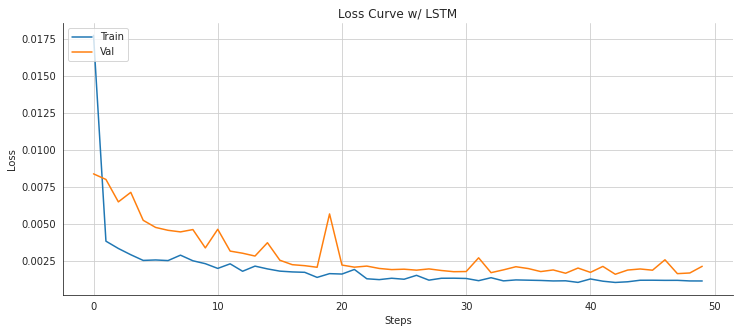

In [30]:
loss_plot(history, epochs=epoch, rnn_type ="LSTM")

In [42]:
print(MAE_LSTM, MAPE_LSTM, MDAPE_LSTM)

57.22547726514863 2.701386485619376 2.393350772449087


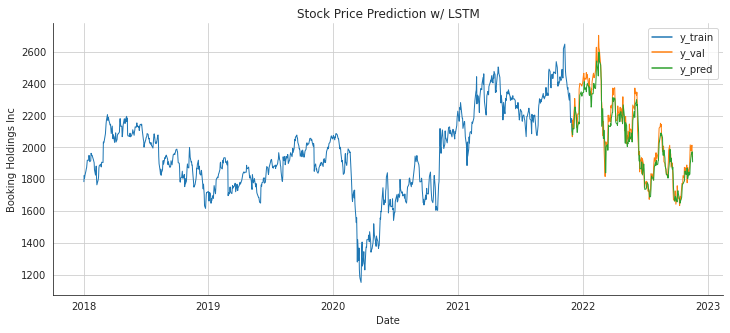

In [31]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_LSTM, stock_company, display_start_date = start_date, rnn_type ="LSTM")

# GRU

In [43]:
sequence_length = 50 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)

h0 = x_train.shape[1] * x_train.shape[2]


(1231, 5)


In [45]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"

GRU_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]),  rnn_type='GRU',lr=lr, loss=loss)
history, y_pred_GRU, MAE_GRU, MAPE_GRU, MDAPE__GRU = evaluate(GRU_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
30/30 [==============================] - 7s 48ms/step - loss: 0.0166 - val_loss: 0.0039
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 5/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 6/50
30/30 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 10/50
30/30 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 11/

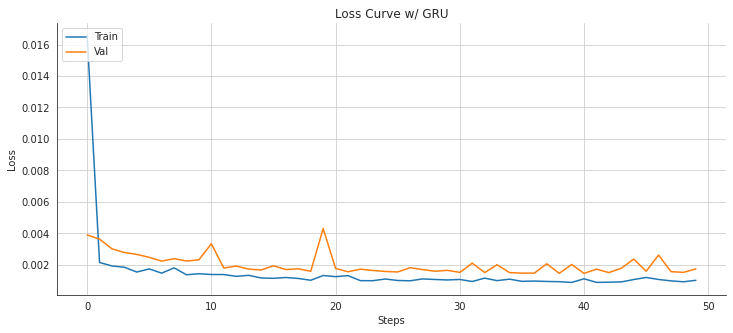

In [46]:
loss_plot(history, epochs=epoch, rnn_type ="GRU")

In [47]:
print(MAE_GRU, MAPE_GRU, MDAPE__GRU)

51.94777425130209 2.4658272001661734 2.1494518341103865


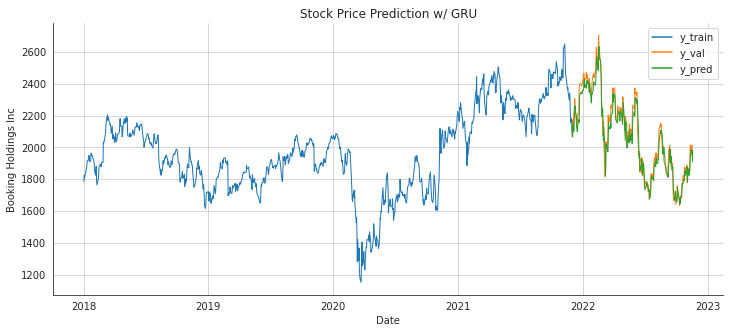

In [49]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_GRU, stock_company, display_start_date = start_date, rnn_type ="GRU")

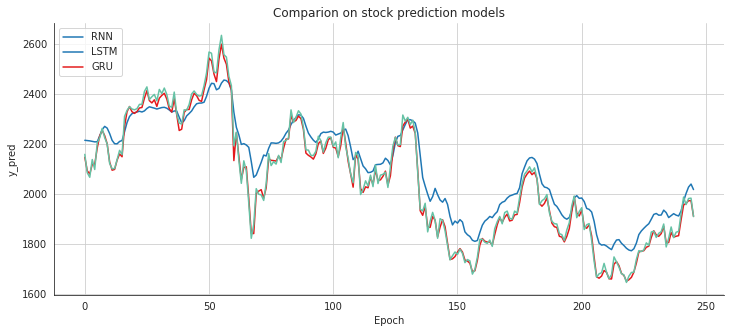

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=y_pred_simplernn)
sns.lineplot(data=y_pred_LSTM, palette="Set1")
sns.lineplot(data=y_pred_GRU,  palette="Set2")
plt.title("Comparion on stock prediction models")
plt.ylabel("y_pred")
plt.xlabel("Epoch")
plt.legend(["RNN", "LSTM", "GRU"], loc="upper left")
plt.grid()
plt.show()

# Predict Next Day


In [84]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(stock_features)

N = sequence_length

last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = LSTM_model.predict(np.array(X_test_new)) #try best model
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

now_price = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
delta = np.round(100 - (now_price * 100)/predicted_price, 2)
print(end_date)
print('predicted price: ', predicted_price)
print('actual price: ', now_price)
print('delta: ', delta, '%')

1/1 [==============================] - 0s 22ms/step
2022-11-20
predicted price:  1906.48
actual price:  1940.28
delta:  -1.77 %
